In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
from zipfile import ZipFile
from google.colab import drive
drive.mount('/content/drive')
file_name = 'drive/MyDrive/filesToColab/datasetNorm.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('datasets')
  print('Done')

Mounted at /content/drive
Done


Запускать только с ускорителем gpu, иначе он не обучается и выдает ошибку, последнюю часть кода пока не затестил из-за этой же проблемы

## Install Ultralytics Package

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.7/644.7 kB 6.2 MB/s eta 0:00:00


## Download the Dataset

In [3]:
#os.makedirs('datasets', exist_ok=True)

In [4]:
%cd datasets

/content/datasets


In [5]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
'''
download_file(
    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',
    'pothole_dataset_v8.zip'
)
'''

"\ndownload_file(\n    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',\n    'pothole_dataset_v8.zip'\n)\n"

In [6]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")
'''
unzip('pothole_dataset_v8.zip')
'''

"\nunzip('pothole_dataset_v8.zip')\n"

In [7]:
%cd ..

/content


## Visualize Images from the Dataset

In [8]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[1:]
                #print(bbox_string.split(' '))
                empty_par,x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

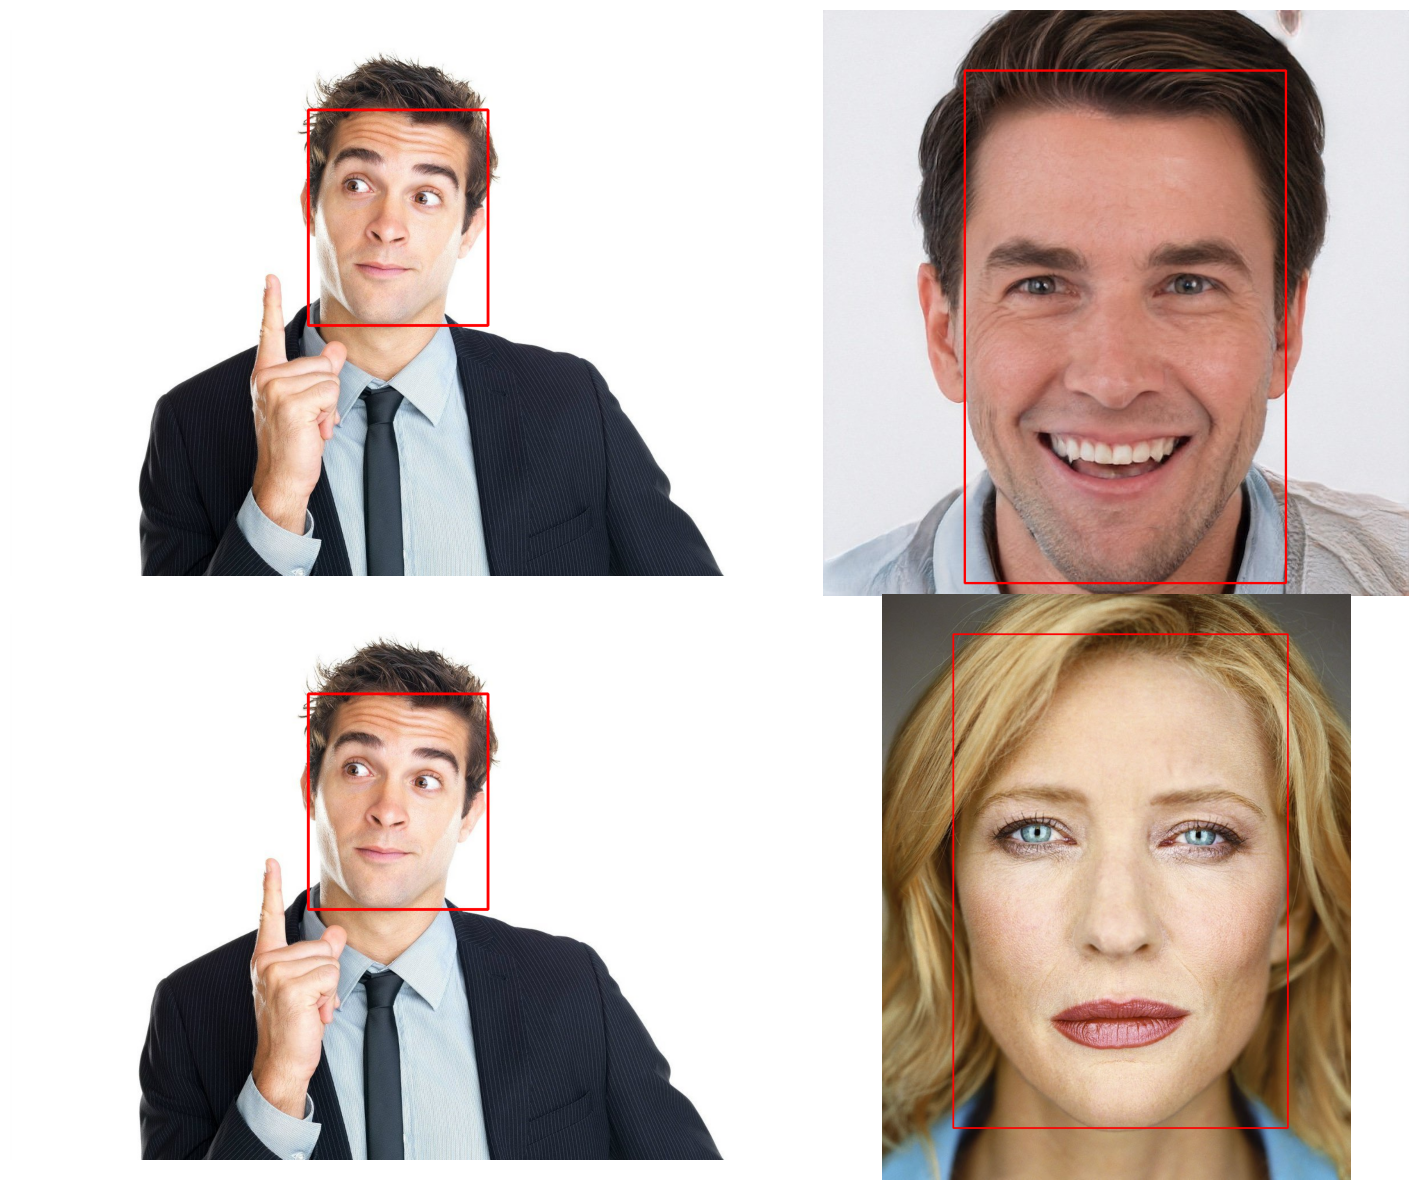

In [11]:
# Visualize a few training images.
plot(
    image_paths='datasets/train/images/',
    label_paths='datasets/train/labels/',
    num_samples=4,
)

## Dataset YAML File

In [12]:
%%writefile pothole_v8.yaml

train: 'train/images'
val: 'valid/images'

# class names
names:
    0 : 'face'


Writing pothole_v8.yaml


## YOLOv8 Nano Training

In [13]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8m.pt imgsz=1280 data=pothole_v8.yaml epochs={EPOCHS} batch=8 name=yolov8m_v8_50e

100% 49.7M/49.7M [00:00<00:00, 129MB/s]
Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=pothole_v8.yaml, epochs=5, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, for

## Evaluation on Validation Images

In [14]:
!yolo task=detect mode=val model=runs/detect/yolov8m_v8_50e/weights/best.pt name=yolov8m_eval data=pothole_v8.yaml

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 419, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 97, in __init__
    self._load(model, task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 149, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 628, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 567, in torch_safe_load
    return torch.load(file, map_location='cpu'), file  # load
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened

## Inference on Validation Images

In [15]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8m_v8_50e/weights/best.pt \
source=datasets/valid/images \
imgsz=1280 \
name=yolov8m_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 419, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 97, in __init__
    self._load(model, task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 149, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 628, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 567, in torch_safe_load
    return torch.load(file, map_location='cpu'), file  # load
  Fil

## Visualize Validation Results

In [16]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [17]:
visualize('runs/detect/yolov8m_v8_50e_infer1280/')

<Figure size 2000x1200 with 0 Axes>

In [18]:
!yolo export model=./content/yolov8m.pt format=tflite

100% 49.7M/49.7M [00:00<00:00, 240MB/s]
Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from 'content/yolov8m.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)
2023-10-24 23:22:38.858146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 23:22:38.858216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 23:22:38.858256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
requirements: Ultralytics 

In [19]:
import numpy as np
import cv2
import torch
import onnx
from google.colab.patches import cv2_imshow
import torchvision
import tensorflow as tf
!pip install onnxruntime
!pip install onnx
def img2tensor(img: np.ndarray, mean: list, std: list, size: int = 224) -> torch.Tensor:
  t = cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA)
  t = torch.from_numpy(t.astype(np.float32)/ 255.0) # 0..255->0..1
  t = t.permute(2,0,1) # hwc -> chw
  _m = torch.FloatTensor(mean).unsqueeze(1).unsqueeze(1) #cx1x1
  _s = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
  t = (t - _m) / (_s + 1E-7)
  return t
image = cv2.imread('datasets/valid/images/1 (37).jpg', cv2.IMREAD_COLOR)
y = img2tensor(image, mean=[0, 0, 0], std=[1, 1, 1],size=640).unsqueeze(0)

In [20]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="/content/content/yolov8s_saved_model/yolov8s_float32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_data = np.array(y.permute(0,2,3,1))
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

ValueError: ignored

In [ ]:
output_data.shape

In [ ]:
out = output_data.copy()
out[:, :4, :] *= 640


def xywh2xyxy(x):
  y = np.copy(x)
  y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
  y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
  y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
  y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
  return y

kx = image.shape[1] / 640
ky = image.shape[0] / 640

elem_out = out.transpose(0, 2, 1).squeeze()
#print(elem_out.shape)

boxes = elem_out[:, :4] * np.array([[kx, ky, kx, ky]])
boxes = xywh2xyxy(boxes)
probs_max_value = elem_out[:, 4:].max(axis=1)
probs_max_index = elem_out[:, 4:].argmax(axis=1)

threshold = 0.1

filter_mask =  (probs_max_value-np.min(probs_max_value))/(np.max(probs_max_value)-np.min(probs_max_value)) > threshold

f_boxes = boxes[filter_mask].astype(np.int32)
f_probs_max_value = probs_max_value[filter_mask]
f_probs_max_index = probs_max_index[filter_mask]

keeps_elements = torchvision.ops.nms(
    torch.from_numpy(f_boxes.astype(np.float32)),
    torch.from_numpy(f_probs_max_value),
    0.5
  )

f_boxes = f_boxes[keeps_elements]
f_probs_max_value = f_probs_max_value[keeps_elements]


detection_visualization = image.copy()

for detecion_id in range(len(f_boxes)):
  target_object_box = f_boxes[detecion_id]  # XcYcWH format
  target_object_prob = float(f_probs_max_value[detecion_id])

  detection_visualization = cv2.rectangle(
      detection_visualization,
      tuple(target_object_box[:2]),
      tuple(target_object_box[2:]),
      (50, 20, 200),
      5
  )

detection_visualization = cv2.resize(detection_visualization, None, fx=1/4, fy=1/4)

cv2_imshow(detection_visualization)